In [63]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Cargar y preparar el dataset
df = pd.read_csv('cangas_IU_todo.csv')
df = df[['fecha', 'abierto/cerrado']].rename(columns={'fecha': 'ds', 'abierto/cerrado': 'y'})

# Convertir la columna de fechas a formato datetime
df['ds'] = pd.to_datetime(df['ds'])

# Dividir los datos en entrenamiento y prueba
train_size = 0.7  # 70% para entrenamiento
train, test = train_test_split(df, train_size=train_size, shuffle=False, random_state=12)

# Inicializar el modelo Prophet desactivando la tendencia y la estacionalidad
model = Prophet(growth='flat')

# Entrenar el modelo
model.fit(train)

# Realizar predicciones en el conjunto de prueba
future = test[['ds']].copy()  # Utilizar las fechas del conjunto de prueba para las predicciones
forecast = model.predict(future)

# Convertir las predicciones en valores binarios
threshold = 0.5  # Umbral para la clasificación
forecast['yhat_binary'] = (forecast['yhat'] > threshold).astype(int)

# Evaluar el modelo
accuracy = accuracy_score(test['y'], forecast['yhat_binary'])
conf_matrix = confusion_matrix(test['y'], forecast['yhat_binary'])
class_report = classification_report(test['y'], forecast['yhat_binary'])

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


11:04:40 - cmdstanpy - INFO - Chain [1] start processing
11:04:40 - cmdstanpy - INFO - Chain [1] done processing


Accuracy: 0.75
Confusion Matrix:
[[259 177]
 [ 74 477]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       436
           1       0.73      0.87      0.79       551

    accuracy                           0.75       987
   macro avg       0.75      0.73      0.73       987
weighted avg       0.75      0.75      0.74       987



11:04:40 - cmdstanpy - INFO - Chain [1] start processing
11:04:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmarc\AppData\Local\Packages\PythonSoftwareFou

Average Accuracy: 0.72
Average Confusion Matrix:
[[139.75 130.75]
 [ 50.25 336.25]]
Average Classification Report:
{'0': {'precision': 0.5609919938583022, 'recall': 0.5637440504243783, 'f1-score': 0.5414981234361969}, '1': {'precision': 0.7573609528682341, 'recall': 0.8785904192185349, 'f1-score': 0.7918524502766459}}


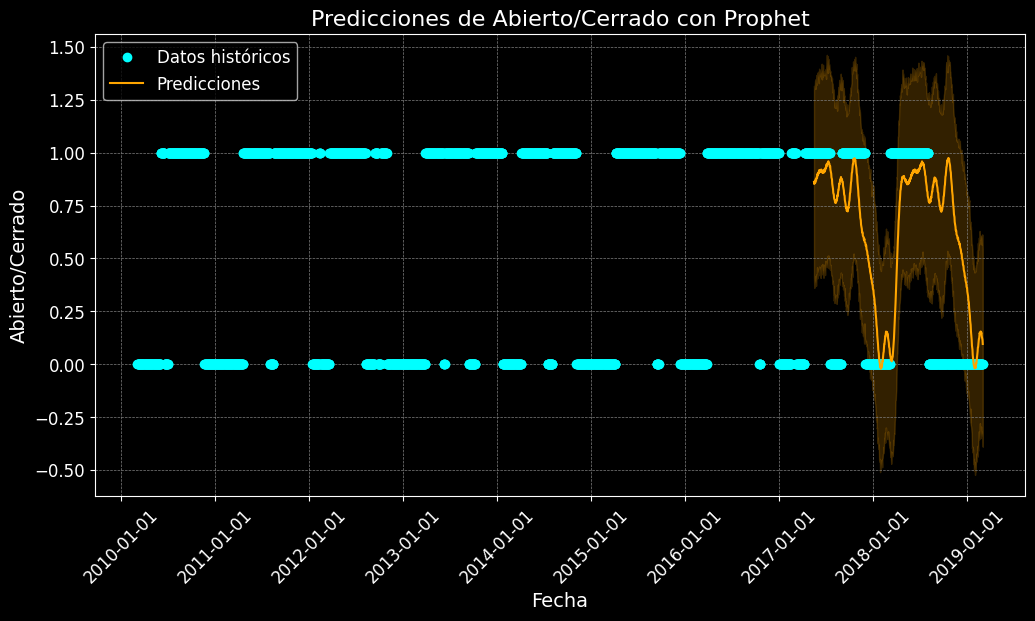

In [64]:
#Claro, una forma más robusta de dividir los datos en conjuntos de entrenamiento y prueba es utilizar la validación cruzada. En particular, puedes usar la validación cruzada de tipo "time series split" (división por series temporales) para evitar la fuga de datos y respetar la naturaleza secuencial de los datos temporales.
#En la validación cruzada para series temporales, los datos se dividen en varios pliegues (folds), y cada pliegue se utiliza a su vez como conjunto de prueba mientras que los anteriores se utilizan como conjunto de entrenamiento. Esto es más adecuado para datos de series temporales porque mantiene el orden temporal de los datos y evita que se utilicen datos futuros para predecir datos pasados.
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


# Cargar y preparar el dataset
df = pd.read_csv('cangas_IU_todo.csv')
df = df[['fecha', 'abierto/cerrado']].rename(columns={'fecha': 'ds', 'abierto/cerrado': 'y'})

# Convertir la columna de fechas a formato datetime
df['ds'] = pd.to_datetime(df['ds'])



# Definir TimeSeriesSplit para la validación cruzada
tscv = TimeSeriesSplit(n_splits=4)

accuracies = []
conf_matrices = []
reports = []

for train_index, test_index in tscv.split(df):
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]

    # Inicializar un nuevo modelo Prophet para cada pliegue
    model = Prophet(growth='flat')

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(train_df)

    # Realizar predicciones en el conjunto de prueba
    future = test_df[['ds']].copy()  # Utilizar las fechas del conjunto de prueba para las predicciones
    forecast = model.predict(future)

    # Convertir las predicciones en valores binarios
    threshold = 0.5  # Umbral para la clasificación
    forecast['yhat_binary'] = (forecast['yhat'] > threshold).astype(int)

    # Evaluar el modelo
    accuracy = accuracy_score(test_df['y'], forecast['yhat_binary'])
    accuracies.append(accuracy)
    conf_matrix = confusion_matrix(test_df['y'], forecast['yhat_binary'])
    conf_matrices.append(conf_matrix)
    class_report = classification_report(test_df['y'], forecast['yhat_binary'], output_dict=True)
    reports.append(class_report)

# Calcular las métricas promedio
avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Calcular el promedio del reporte de clasificación
# Inicializar un diccionario vacío para almacenar las métricas promedio
avg_precision_0 = []
avg_precision_1 = []
avg_recall_0 = []
avg_recall_1 = []
avg_f1_score_0 = []
avg_f1_score_1 = []

# Calcular las medias de cada métrica
for report in reports:
    avg_precision_0.append(report['0']['precision'])
    avg_precision_1.append(report['1']['precision'])
    avg_recall_0.append(report['0']['recall'])
    avg_recall_1.append(report['1']['recall'])
    avg_f1_score_0.append(report['0']['f1-score'])
    avg_f1_score_1.append(report['1']['f1-score'])

avg_report = {
    '0': {
        'precision': np.mean(avg_precision_0),
        'recall': np.mean(avg_recall_0),
        'f1-score': np.mean(avg_f1_score_0)
    },
    '1': {
        'precision': np.mean(avg_precision_1),
        'recall': np.mean(avg_recall_1),
        'f1-score': np.mean(avg_f1_score_1)
    }
}

print(f"Average Accuracy: {avg_accuracy:.2f}")
print("Average Confusion Matrix:")
print(avg_conf_matrix)
print("Average Classification Report:")
print(avg_report)

# Personalizar la gráfica con fondo oscuro y colores llamativos
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['ds'], df['y'], 'o', label='Datos históricos', color='cyan')
ax.plot(forecast['ds'], forecast['yhat'], '-', label='Predicciones', color='orange')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Abierto/Cerrado', fontsize=14)
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Predicciones de Abierto/Cerrado con Prophet', fontsize=16)

# Personalización adicional del gráfico
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.show()

11:04:41 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmarc\AppData\Local\Packages\PythonSoftwareFou

Average Accuracy: 0.72
Average Confusion Matrix:
[[139.75 130.75]
 [ 50.25 336.25]]
Average Classification Report:
{'0': {'precision': 0.5609919938583022, 'recall': 0.5637440504243783, 'f1-score': 0.5414981234361969}, '1': {'precision': 0.7573609528682341, 'recall': 0.8785904192185349, 'f1-score': 0.7918524502766459}}


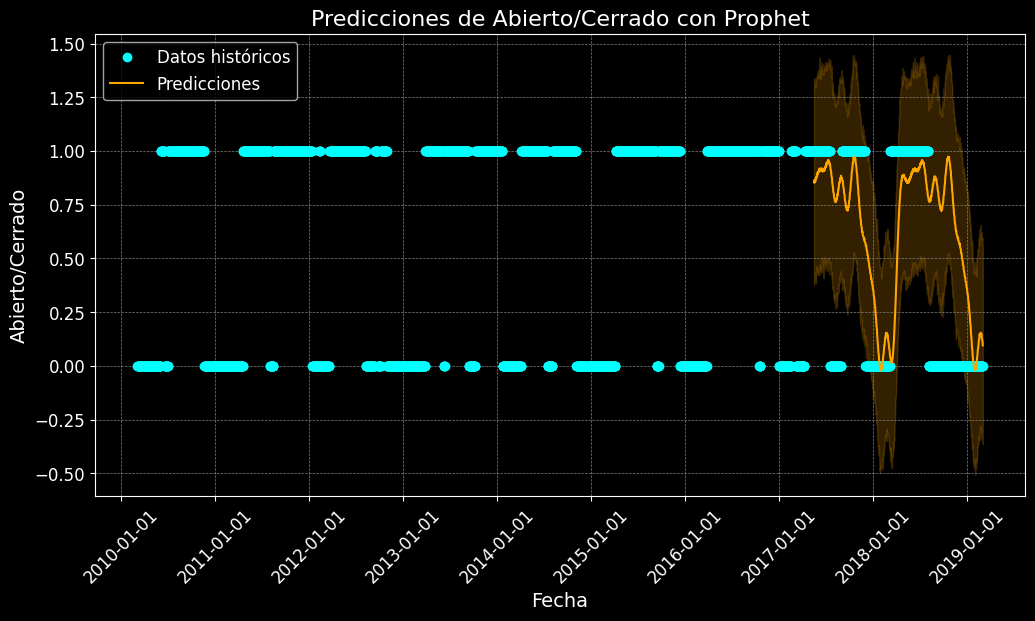

In [65]:
#Claro, una forma más robusta de dividir los datos en conjuntos de entrenamiento y prueba es utilizar la validación cruzada. En particular, puedes usar la validación cruzada de tipo "time series split" (división por series temporales) para evitar la fuga de datos y respetar la naturaleza secuencial de los datos temporales.
#En la validación cruzada para series temporales, los datos se dividen en varios pliegues (folds), y cada pliegue se utiliza a su vez como conjunto de prueba mientras que los anteriores se utilizan como conjunto de entrenamiento. Esto es más adecuado para datos de series temporales porque mantiene el orden temporal de los datos y evita que se utilicen datos futuros para predecir datos pasados.
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


# Cargar y preparar el dataset
df = pd.read_csv('cangas_IU_todo.csv')
df = df[['fecha', 'abierto/cerrado']].rename(columns={'fecha': 'ds', 'abierto/cerrado': 'y'})

# Convertir la columna de fechas a formato datetime
df['ds'] = pd.to_datetime(df['ds'])



# Definir TimeSeriesSplit para la validación cruzada
tscv = TimeSeriesSplit(n_splits=4)

accuracies = []
conf_matrices = []
reports = []

for train_index, test_index in tscv.split(df):
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]

    # Inicializar un nuevo modelo Prophet para cada pliegue
    model = Prophet(growth='flat')

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(train_df)

    # Realizar predicciones en el conjunto de prueba
    future = test_df[['ds']].copy()  # Utilizar las fechas del conjunto de prueba para las predicciones
    forecast = model.predict(future)

    # Convertir las predicciones en valores binarios
    threshold = 0.5  # Umbral para la clasificación
    forecast['yhat_binary'] = (forecast['yhat'] > threshold).astype(int)

    # Evaluar el modelo
    accuracy = accuracy_score(test_df['y'], forecast['yhat_binary'])
    accuracies.append(accuracy)
    conf_matrix = confusion_matrix(test_df['y'], forecast['yhat_binary'])
    conf_matrices.append(conf_matrix)
    class_report = classification_report(test_df['y'], forecast['yhat_binary'], output_dict=True)
    reports.append(class_report)

# Calcular las métricas promedio
avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Calcular el promedio del reporte de clasificación
# Inicializar un diccionario vacío para almacenar las métricas promedio
avg_precision_0 = []
avg_precision_1 = []
avg_recall_0 = []
avg_recall_1 = []
avg_f1_score_0 = []
avg_f1_score_1 = []

# Calcular las medias de cada métrica
for report in reports:
    avg_precision_0.append(report['0']['precision'])
    avg_precision_1.append(report['1']['precision'])
    avg_recall_0.append(report['0']['recall'])
    avg_recall_1.append(report['1']['recall'])
    avg_f1_score_0.append(report['0']['f1-score'])
    avg_f1_score_1.append(report['1']['f1-score'])

avg_report = {
    '0': {
        'precision': np.mean(avg_precision_0),
        'recall': np.mean(avg_recall_0),
        'f1-score': np.mean(avg_f1_score_0)
    },
    '1': {
        'precision': np.mean(avg_precision_1),
        'recall': np.mean(avg_recall_1),
        'f1-score': np.mean(avg_f1_score_1)
    }
}

print(f"Average Accuracy: {avg_accuracy:.2f}")
print("Average Confusion Matrix:")
print(avg_conf_matrix)
print("Average Classification Report:")
print(avg_report)

# Personalizar la gráfica con fondo oscuro y colores llamativos
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['ds'], df['y'], 'o', label='Datos históricos', color='cyan')
ax.plot(forecast['ds'], forecast['yhat'], '-', label='Predicciones', color='orange')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Abierto/Cerrado', fontsize=14)
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Predicciones de Abierto/Cerrado con Prophet', fontsize=16)

# Personalización adicional del gráfico
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.show()

Epoch 1/50


C:\Users\rmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7102 - loss: 0.4755 - val_accuracy: 0.9478 - val_loss: 0.1908
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9246 - loss: 0.2300 - val_accuracy: 0.9565 - val_loss: 0.1305
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9400 - loss: 0.1809 - val_accuracy: 0.9739 - val_loss: 0.1060
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.1410 - val_accuracy: 0.9783 - val_loss: 0.0946
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9620 - loss: 0.1306 - val_accuracy: 0.9826 - val_loss: 0.0814
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9706 - loss: 0.1153 - val_accuracy: 0.9783 - val_loss: 0.0799
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9707 - loss: 0.1019 - val_accuracy: 0.9826 - val_loss: 0.0701
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9731 - loss: 0.0982 - val_accuracy: 0.9826 - val_

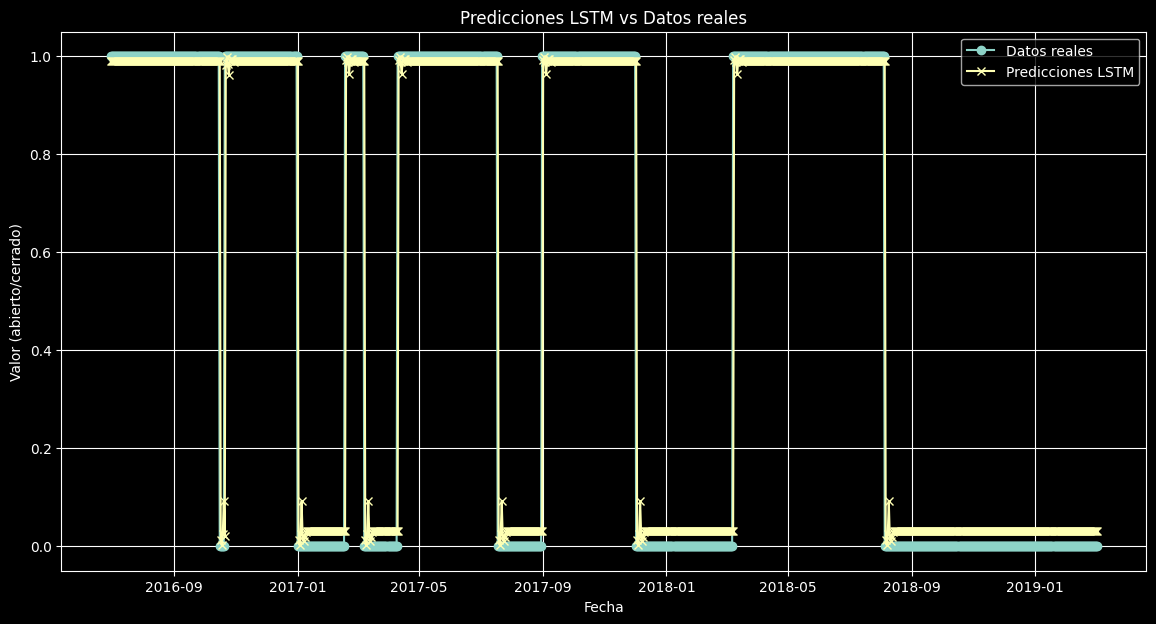

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Cargar y preparar el dataset
df = pd.read_csv('cangas_IU_todo.csv')
df = df[['fecha', 'abierto/cerrado']].rename(columns={'fecha': 'ds', 'abierto/cerrado': 'y'})

# Convertir la columna de fechas a formato datetime
df['ds'] = pd.to_datetime(df['ds'])

# Ordenar los datos por fecha si no están ordenados
df = df.sort_values(by='ds')

# Escalar los datos si es necesario (en este caso, solo si es beneficioso)
scaler = MinMaxScaler(feature_range=(0, 1))
df[['y']] = scaler.fit_transform(df[['y']])

# Función para crear secuencias temporales
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Convertir los datos a arrays numpy
data = df[['y']].values

# Definir el número de pasos temporales para el modelo LSTM
time_steps = 10

# Crear secuencias temporales
X, y = create_sequences(data, time_steps)

# Dividir los datos en entrenamiento y prueba
train_size = 0.7  # 70% para entrenamiento
split_index = int(train_size * len(data))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape de los datos para que sean compatibles con LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Definir modelo LSTM
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compilar modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar modelo LSTM
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Desescalar los datos para obtener las predicciones reales
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_rescaled = scaler.inverse_transform(y_pred).flatten()

# Calcular el porcentaje de acierto (accuracy)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generar el reporte de clasificación
class_report = classification_report(y_test, y_pred_binary)
print("Classification Report:")
print(class_report)

# Visualizar las predicciones y los datos reales en un gráfico
plt.figure(figsize=(14, 7))
plt.plot(df['ds'][-len(y_test):], y_test_rescaled, label='Datos reales', marker='o')
plt.plot(df['ds'][-len(y_test):], y_pred_rescaled, label='Predicciones LSTM', marker='x')
plt.title('Predicciones LSTM vs Datos reales')
plt.xlabel('Fecha')
plt.ylabel('Valor (abierto/cerrado)')
plt.legend()
plt.grid(True)
plt.show()
